In [55]:
from datasets import load_dataset

ds = load_dataset("Deysi/spam-detection-dataset")

In [56]:
train = ds['train']
test = ds['test']

In [57]:
train[0]

{'text': 'hey I am looking for Xray baggage datasets can you provide me with the same ',
 'label': 'not_spam'}

In [58]:
train.shape

(8175, 2)

In [59]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Convert datasets to pandas DataFrames
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)


# 1. Inspect the actual labels
print("Original unique labels:", train_df['label'].unique())
print("Sample of original data:")
print(train_df.head())

# 2. Map text labels to numeric labels (0 and 1)
label_map = {'spam': 1, 'not_spam': 0} 

# Check if the labels are already numeric 
if set(train_df['label'].unique()) == {'0', '1'}:
    print("Labels are strings ('0', '1'). Converting to integers.")
    train_df['label'] = pd.to_numeric(train_df['label'])
    test_df['label'] = pd.to_numeric(test_df['label'])
# Check for text labels
elif 'spam' in train_df['label'].unique():
    print("Labels are text ('spam', 'ham'). Mapping to integers.")
    train_df['label'] = train_df['label'].map(label_map)
    test_df['label'] = test_df['label'].map(label_map)
else:
    print("Warning: Could not automatically determine label mapping. Please inspect unique labels.")

print("\nMapped unique labels:", train_df['label'].unique())
print("Sample of mapped data:")
print(train_df.head())



if 'message' in train_df.columns:
    train_df = train_df.rename(columns={'message': 'text'})
    test_df = test_df.rename(columns={'message': 'text'})


Original unique labels: ['not_spam' 'spam']
Sample of original data:
                                                text     label
0  hey I am looking for Xray baggage datasets can...  not_spam
1  "Get rich quick! Make millions in just days wi...      spam
2  URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...      spam
3  [Google AI Blog: Contributing Data to Deepfake...  not_spam
4  Trying to see if anyone already has timestamps...  not_spam
Labels are text ('spam', 'ham'). Mapping to integers.

Mapped unique labels: [0 1]
Sample of mapped data:
                                                text  label
0  hey I am looking for Xray baggage datasets can...      0
1  "Get rich quick! Make millions in just days wi...      1
2  URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...      1
3  [Google AI Blog: Contributing Data to Deepfake...      0
4  Trying to see if anyone already has timestamps...      0


Label counts found: [4050, 4125]


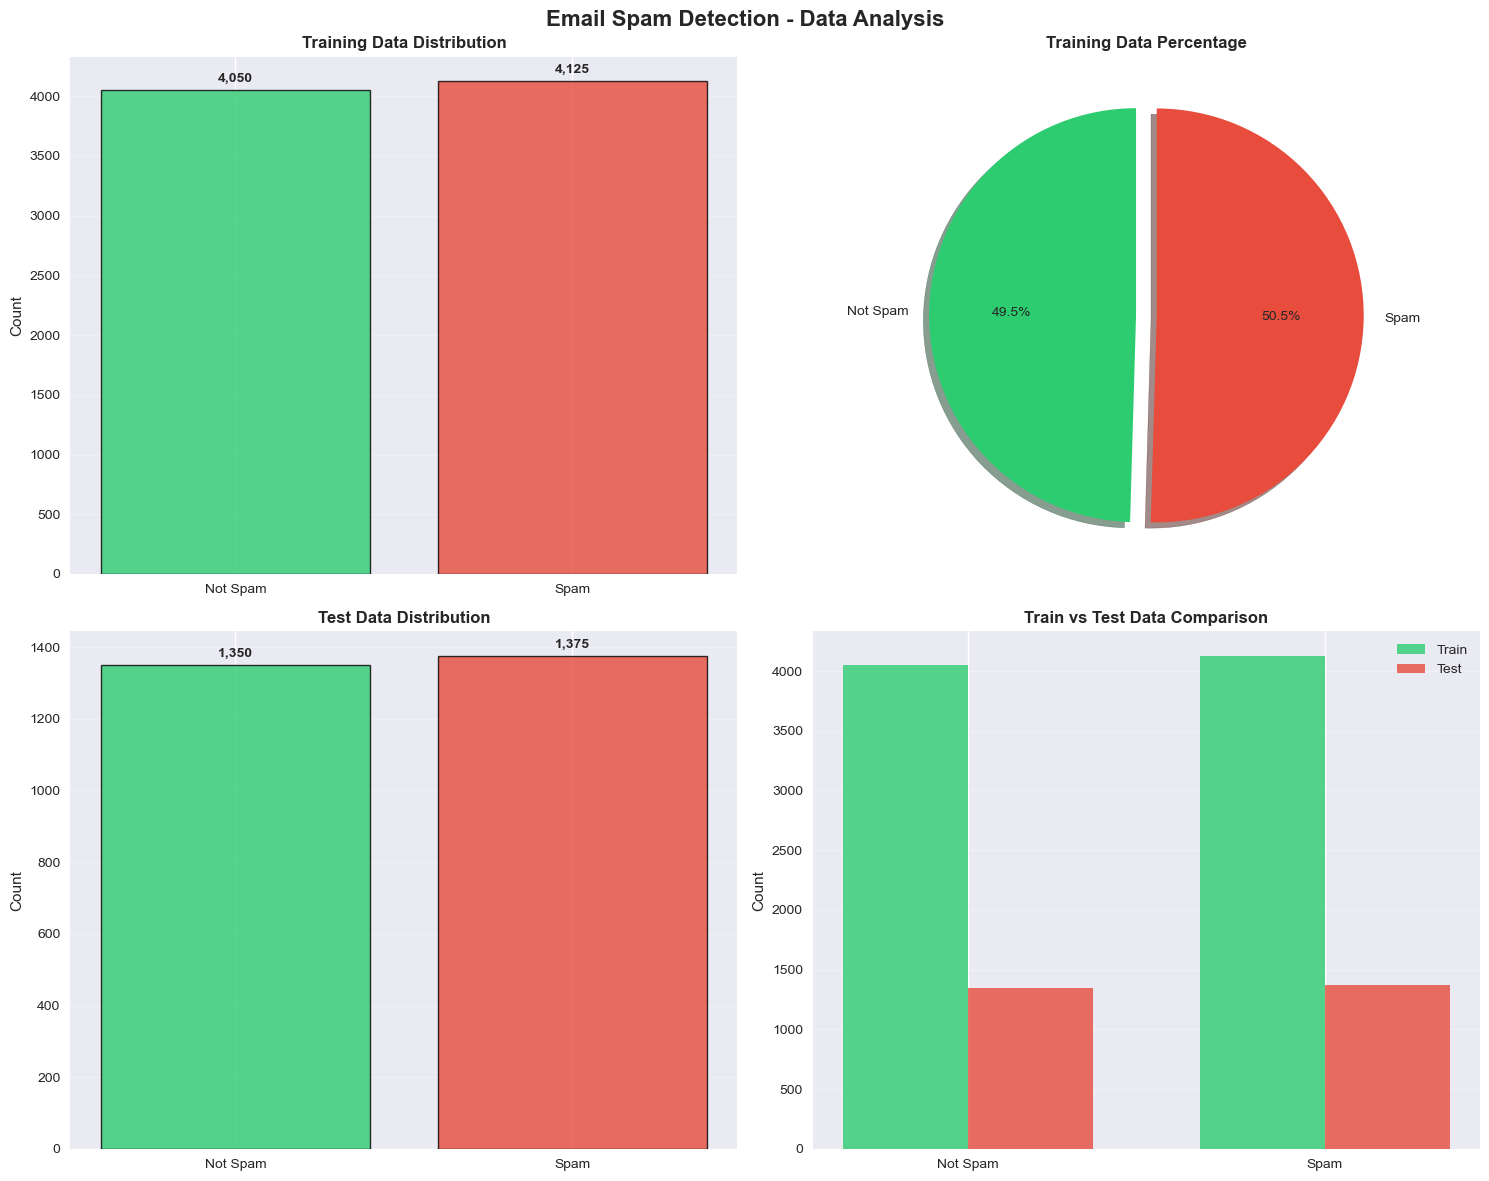

In [60]:
### Ai made data representation :(
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Email Spam Detection - Data Analysis', fontsize=16, fontweight='bold')

# Use DataFrame if converted
if 'train_df' in locals():
    train_data = train_df
    test_data = test_df
else:
    train_data = train
    test_data = test

# 1. Training Data Distribution - Bar Chart
if 'label' not in train_data.columns:
    raise KeyError("The required 'label' column is not in the training data. Please check column names.")
if not pd.api.types.is_numeric_dtype(train_data['label']):
    print("Warning: 'label' column is not numeric. Attempting to convert.")
    train_data['label'] = pd.to_numeric(train_data['label'], errors='coerce').fillna(-1)


train_counts = Counter(train_data['label'])
labels = ['Not Spam', 'Spam']
counts = [train_counts.get(0, 0), train_counts.get(1, 0)]
colors = ['#2ecc71', '#e74c3c']


print(f"Label counts found: {counts}")
if sum(counts) == 0:
    print("\nERROR: No data found for labels 0 or 1. Cannot generate plots.")

else:
    bars = axes[0, 0].bar(labels, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    axes[0, 0].set_title('Training Data Distribution', fontweight='bold')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(axis='y', alpha=0.3)


    for bar, count in zip(bars, counts):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + max(counts) * 0.01,
                       f'{count:,}', ha='center', va='bottom', fontweight='bold')

    # 2. Training Data Distribution - Pie Chart (with check)
    if sum(counts) > 0:  # Only draw pie chart if there is data
        wedges, texts, autotexts = axes[0, 1].pie(counts, labels=labels, autopct='%1.1f%%', 
                                                 startangle=90, colors=colors,
                                                 explode=(0.05, 0.05), shadow=True)
        axes[0, 1].set_title('Training Data Percentage', fontweight='bold')
    else:
        axes[0, 1].text(0.5, 0.5, 'No data to display', ha='center', va='center')
        axes[0, 1].set_title('Training Data Percentage', fontweight='bold')


    # 3. Test Data Distribution - Bar Chart
    test_counts = Counter(test_data['label'])
    test_counts_list = [test_counts.get(0, 0), test_counts.get(1, 0)]

    bars2 = axes[1, 0].bar(labels, test_counts_list, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    axes[1, 0].set_title('Test Data Distribution', fontweight='bold')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, count in zip(bars2, test_counts_list):
        height = bar.get_height()
        # Add a small check to avoid error if max is 0
        offset = max(test_counts_list) * 0.01 if max(test_counts_list) > 0 else 1
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + offset,
                       f'{count:,}', ha='center', va='bottom', fontweight='bold')

    # 4. Train vs Test Comparison
    x = np.arange(len(labels))
    width = 0.35

    bars3 = axes[1, 1].bar(x - width/2, counts, width, label='Train', color=colors[0], alpha=0.8)
    bars4 = axes[1, 1].bar(x + width/2, test_counts_list, width, label='Test', color=colors[1], alpha=0.8)

    axes[1, 1].set_title('Train vs Test Data Comparison', fontweight='bold')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(labels)
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract texts and labels
X_train_text = train_df['text']
y_train = train_df['label']
X_test_text = test_df['text']
y_test = test_df['label']

## Vectoriztion
vector= TfidfVectorizer(stop_words='english',max_features=5000)
X_train = vector.fit_transform(X_train_text)
X_test = vector.transform(X_test_text)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (8175, 5000)
Test data shape: (2725, 5000)


In [70]:
from collections import Counter

train_label_counts = Counter(y_train)
test_label_counts = Counter(y_test)

print("Train label counts:", train_label_counts)
print("Test label counts:", test_label_counts)

Train label counts: Counter({1: 4125, 0: 4050})
Test label counts: Counter({1: 1375, 0: 1350})


In [71]:
from sklearn.svm import SVC

#linear 
model = SVC(kernel='linear')
model.fit(X_train,y_train)

SVC(kernel='linear')

In [72]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

y_pred = model.predict(X_test)

# Fixed order: y_true, y_pred (not y_pred, y_true)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9970642201834863
Confusion Matrix: 
[[1347    3]
 [   5 1370]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1350
           1       1.00      1.00      1.00      1375

    accuracy                           1.00      2725
   macro avg       1.00      1.00      1.00      2725
weighted avg       1.00      1.00      1.00      2725



In [73]:
### Check authenticity of dataset
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=5)
print("CV scores:", scores)
print("Mean:", scores.mean())


CV scores: [0.99449541 0.99755352 0.99633028 0.9969419  0.99877676]
Mean: 0.9968195718654436


In [74]:
def predict_spam(email_text):
    email_vector = vector.transform([email_text])
    prediction = model.predict(email_vector)
    
    if prediction[0] == 1:
        return "This email is SPAM."
    else:
        return "This email is NOT SPAM (Ham)."

spam_example = "Free! You've won a free cruise to the Bahamas. Click here to claim your prize now!"
print(f"Email Text: '{spam_example}'")
print(f"Prediction: {predict_spam(spam_example)}\n")

Email Text: 'Free! You've won a free cruise to the Bahamas. Click here to claim your prize now!'
Prediction: This email is SPAM.



In [75]:
spam_example_2 = "URGENT: Your account has been compromised. Please verify your login details immediately to avoid suspension."
print(f"Email Text: '{spam_example_2}'")
print(f"Prediction: {predict_spam(spam_example_2)}")

Email Text: 'URGENT: Your account has been compromised. Please verify your login details immediately to avoid suspension.'
Prediction: This email is NOT SPAM (Ham).
